In [1]:
#Fine tuning a Mask R-CNN model
# Mask means the correct boundary of the person instead of the box surrounding a person
# we will work on pedestrian detection
%mkdir install vlm_app_2

import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
print(device)

cpu


In [6]:
import os
import urllib

def download_file(url, path=None):
    local_filename = None  # Initialize local_filename
    if path is None:
        local_filename = url.split('/')[-1]  # Get the filename from the URL
    else:
        local_filename = path

    if os.path.exists(local_filename):
        print('File already exists.')
        return

    try:
        urllib.URLopener().retrieve(url, local_filename)  # Download the file
    except:
        urllib.request.urlretrieve(url, local_filename)

    print('Downloaded', local_filename)

In [7]:
%mkdir data

# Replace 'htts' with 'https'
download_file("https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip", "data/PennFudanPed.zip")

%cd data
!unzip PennFudanPed.zip

# Download the Penn-Fudan dataset and save it in the data folder

A subdirectory or file data already exists.


Downloaded data/PennFudanPed.zip
c:\Users\bsiva\Desktop\mahesh\Hackathons\til-24-base\Notes\data


C:\Users\bsiva\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


Archive:  PennFudanPed.zip
   creating: PennFudanPed/
  inflating: PennFudanPed/added-object-list.txt  
   creating: PennFudanPed/Annotation/
  inflating: PennFudanPed/Annotation/FudanPed00001.txt  
  inflating: PennFudanPed/Annotation/FudanPed00002.txt  
  inflating: PennFudanPed/Annotation/FudanPed00003.txt  
  inflating: PennFudanPed/Annotation/FudanPed00004.txt  
  inflating: PennFudanPed/Annotation/FudanPed00005.txt  
  inflating: PennFudanPed/Annotation/FudanPed00006.txt  
  inflating: PennFudanPed/Annotation/FudanPed00007.txt  
  inflating: PennFudanPed/Annotation/FudanPed00008.txt  
  inflating: PennFudanPed/Annotation/FudanPed00009.txt  
  inflating: PennFudanPed/Annotation/FudanPed00010.txt  
  inflating: PennFudanPed/Annotation/FudanPed00011.txt  
  inflating: PennFudanPed/Annotation/FudanPed00012.txt  
  inflating: PennFudanPed/Annotation/FudanPed00013.txt  
  inflating: PennFudanPed/Annotation/FudanPed00014.txt  
  inflating: PennFudanPed/Annotation/FudanPed00015.txt  
  i

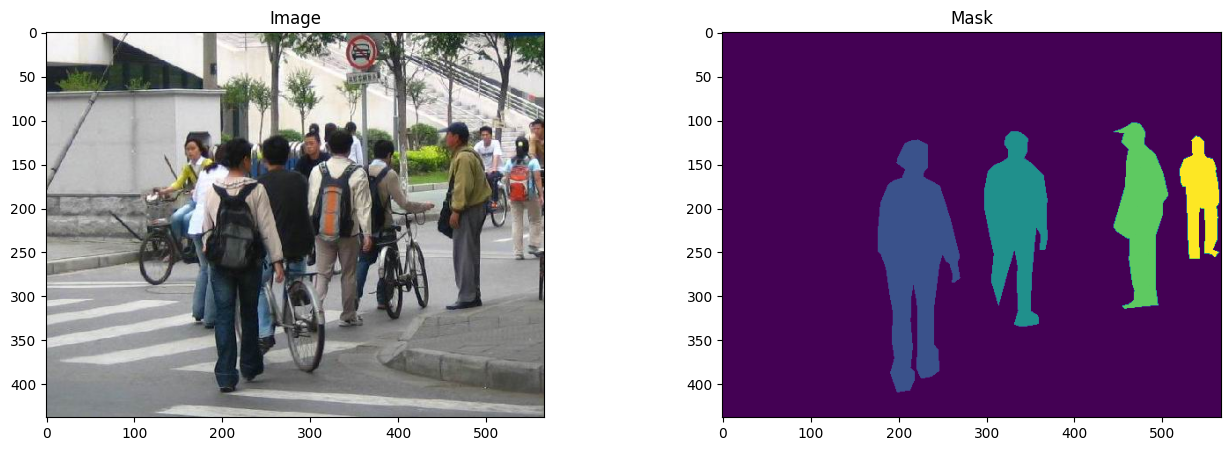

In [8]:
import matplotlib.pyplot as plt
from torchvision.io import read_image

image = read_image("PennFudanPed/PNGImages/FudanPed00046.png")
mask = read_image("PennFudanPed/PedMasks/FudanPed00046_mask.png")

plt.figure(figsize=(16, 5))
plt.subplot(121)
plt.title("Image")
plt.imshow(image.permute(1, 2, 0))
plt.subplot(122)
plt.title("Mask")
plt.imshow(mask.permute(1, 2, 0))

In [9]:
import os
import torch

import torch.utils
from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F

class PennFundanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.images = list(sorted(os.listdir(os.path.join(root, "PNGImages")))) # List of images
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks")))) # List of masks/ functions
    
    def __getitem__(self, idx):
        # Load images and masks
        img_path = os.path.join(self.root, "PNGImages", self.images[idx]) #load image
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx]) #load mask
        img = read_image(img_path)
        mask = read_image(mask_path)
        
        # instances are encoded as different colors
        obj_ids = torch.unique(mask) # For each object, we have a unique color so in this case each person has a unique color
        # first id is the background, so remove it
        obj_ids = obj_ids[1:] # Every color is a mask, as the background also has a color, we remove it
        num_objs = len(obj_ids)
        
        # split the color-encoded mask into a set of binary masks
        masks = mask == obj_ids[:, None, None].to(dtype=torch.uint8)
        
        # get bounding box coordinates for each mask
        boxes = masks_to_boxes(masks) # Finds the boxes around the masks by finding the min and max x,y coordinates
        
        # there is only one class, so we don't need to create a mapping from object_id to class_id all are pedestrians so we can use the same class id
        labels = torch.ones((num_objs,), dtype=torch.int64) 
        
        iamge_id = idx
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64) # All instances not a pedestrian is different from a pedestrian
        
        img = tv_tensors.Image(img)
        
        ## Extracting metadata from the image
        target = {}
        target["boxes"] = tv_tensorsBoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img))
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        target["masks"] = tv_tensors.Mask(masks)
        
        if self.transforms is not None:
            img, target = self.transforms(img, target)
            
        return img, target
    
    def __len__(self):
        return len(self.images)
        

In [10]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# load a pre-trained model for classification and return only the features
backbone = torchvision.models.mobilenet_v2(weights="DEFAULT").features # We are using a pre-trained model called mobilenet_v2
# FasterRCNN needs to know the number of output channels in a backbone. For mobilenet_v2, it's 1280 so we need to add it
backbone.out_channels = 1280

# let's make the RPN generate 5 x 3 anchors per spatial location, with 5 different sizes and 3 different aspect ratios
# We have a feature map of 1/16 the size of the input image
# We have a Tuple[Tuple[int]] because each feature map could have different sizes and aspect ratios
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),), aspect_ratios=((0.5, 1.0, 2.0),))

# let's define what are the feature maps that we will use to perform the region of interest cropping, as well as the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to be [0]. 
# More generally, the backbone should return an OrderedDict[Tensor], and in featmap_names you can choose which feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=[0], output_size=7, sampling_ratio=2)

model = FasterRCNN(backbone, num_classes=2, rpn_anchor_generator=anchor_generator, box_roi_pool=roi_pooler)
#backbone is the feature extractor defined above
#num_classes is the number of classes, pedestrian and background
#rpn_anchor_generator is the anchor generator defined above
#box_roi_pool is the roi_pooler defined above

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to C:\Users\bsiva/.cache\torch\hub\checkpoints\mobilenet_v2-7ebf99e0.pth
100%|██████████| 13.6M/13.6M [00:02<00:00, 6.96MB/s]


In [11]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")
    
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)
    
    return model

In [12]:
from torchinfo import summary

model = get_model_instance_segmentation(2)
summary(model, input_size=(32, 3, 112, 112), verbose=0, col_names=["input_size", "output_size", "num_params"])

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to C:\Users\bsiva/.cache\torch\hub\checkpoints\maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:13<00:00, 12.9MB/s] 
